# HAT-P-67 with blasé: joint stellar/telluric modeling

Here we go!  See discussion at:  
https://github.com/BrownDwarf/disperse/issues/21

In [1]:
%config Completer.use_jedi = False

In [2]:
import torch
from blase.emulator import SparseLogEmulator, ExtrinsicModel, InstrumentalModel
import matplotlib.pyplot as plt
from gollum.phoenix import PHOENIXSpectrum
from gollum.telluric import TelFitSpectrum
from blase.utils import doppler_grid
import astropy.units as u
import numpy as np

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
    
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
device

'cpu'

## Pre-process the data
We will quickly pre-process the HPF spectrum with the [muler](https://muler.readthedocs.io/en/latest/) library

In [4]:
from muler.hpf import HPFSpectrum

In [5]:
fn1 = '/Volumes/pecos/HPF/TACC/UT22-2-019/Goldilocks_20220428T065349_v1.0_0009.spectra.fits'
fn2 = '/Volumes/pecos/HPF/TACC/UT22-2-019/Goldilocks_20220501T063156_v1.0_0042.spectra.fits'

In [6]:
raw_data = HPFSpectrum(file=fn1, order=18) # 6, 14, 18

In [7]:
data = raw_data.sky_subtract().trim_edges().remove_nans().deblaze().normalize(normalize_by='peak')

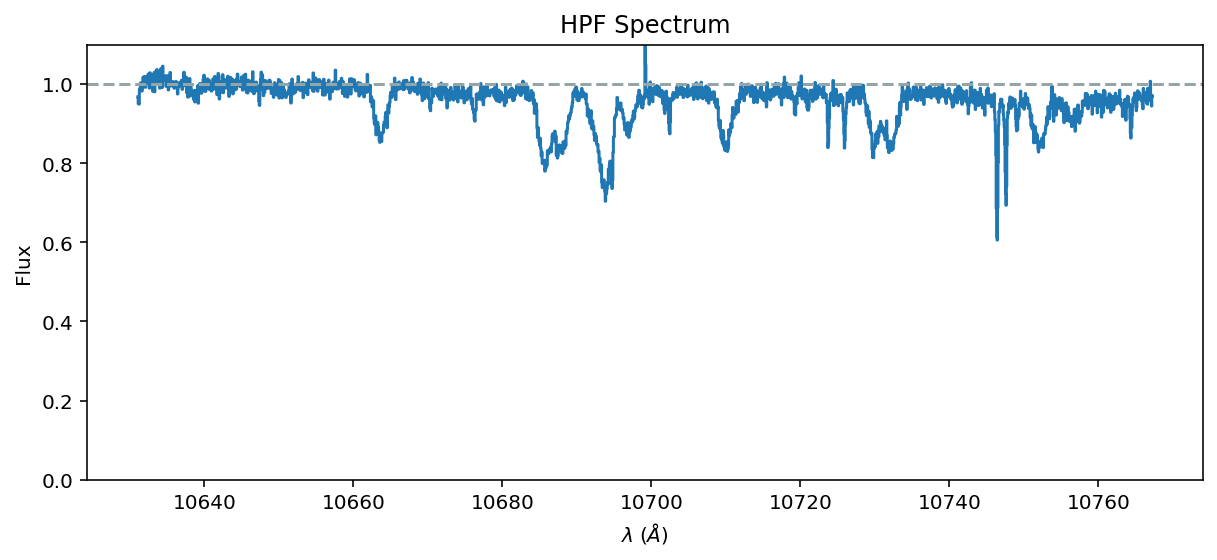

In [8]:
ax = data.plot(yhi=1.1);
ax.axhline(1.0, color='#95a5a6', linestyle='dashed');

In [9]:
wl_lo = 10630-30.0
wl_hi = 10770+30.0
wavelength_grid = doppler_grid(wl_lo, wl_hi)

### Retrieve the Phoenix model

HAT-P-67 has $T_{\mathrm{eff}}=6406\;K$ and $\log{g}=3.854$, according to sources obtained through NASA Exoplanet Archive (Zhou et al. 2017 and references therein).  Let's start with a PHOENIX model possessing these properties.

In [10]:
from scipy.signal import find_peaks

In [11]:
spectrum = PHOENIXSpectrum(teff=6400, logg=4.0, wl_lo=wl_lo, wl_hi=wl_hi)
spectrum = spectrum.divide_by_blackbody()
spectrum = spectrum.normalize()
continuum_fit = spectrum.fit_continuum(polyorder=5)
spectrum = spectrum.divide(continuum_fit, handle_meta="ff")

### Retrieve the TelFit Telluric model

Let's pick a precomputed TelFit model with comparable temperature and humidity as the data.  You can improve on your initial guess by tuning a TelFit model from scratch.  We choose to skip this laborious step here, but encourage practitioners to try it on their own.

In [12]:
data.meta['header']['ENVTEM'], data.meta['header']['ENVHUM'] # Fahrenheit and Relative Humidity

(62.667, 54.406)

That's about 290 Kelvin and 55% humidity.

In [13]:
web_link = 'https://utexas.box.com/shared/static/byw84uwgwl90e8fau4eesud0e28vl59d.txt'

In [14]:
telluric_spectrum_full = TelFitSpectrum(path=web_link).air_to_vacuum()
mask = ((telluric_spectrum_full.wavelength.value > wl_lo) &
        (telluric_spectrum_full.wavelength.value < wl_hi) )
telluric_spectrum = telluric_spectrum_full.apply_boolean_mask(mask)
telluric_wl = telluric_spectrum.wavelength.value
telluric_flux = np.abs(telluric_spectrum.flux.value)
telluric_lnflux = np.log(telluric_flux) # "natural log" or log base `e`
telluric_lnflux[telluric_lnflux < -15] = -15

## Initial guess

In [15]:
system_RV = -1.4 #km/s
BERV = data.estimate_barycorr().to(u.km/u.s).value
observed_RV = system_RV - BERV#km/s
vsini = 35.8 #km/s
resolving_power = 55_000
initial_guess = spectrum.resample_to_uniform_in_velocity()\
                        .rv_shift(observed_RV)\
                        .rotationally_broaden(vsini)\
                        .instrumental_broaden(resolving_power)\
                        .resample(data)

initial_telluric = telluric_spectrum.instrumental_broaden(resolving_power)\
                                         .resample(data)

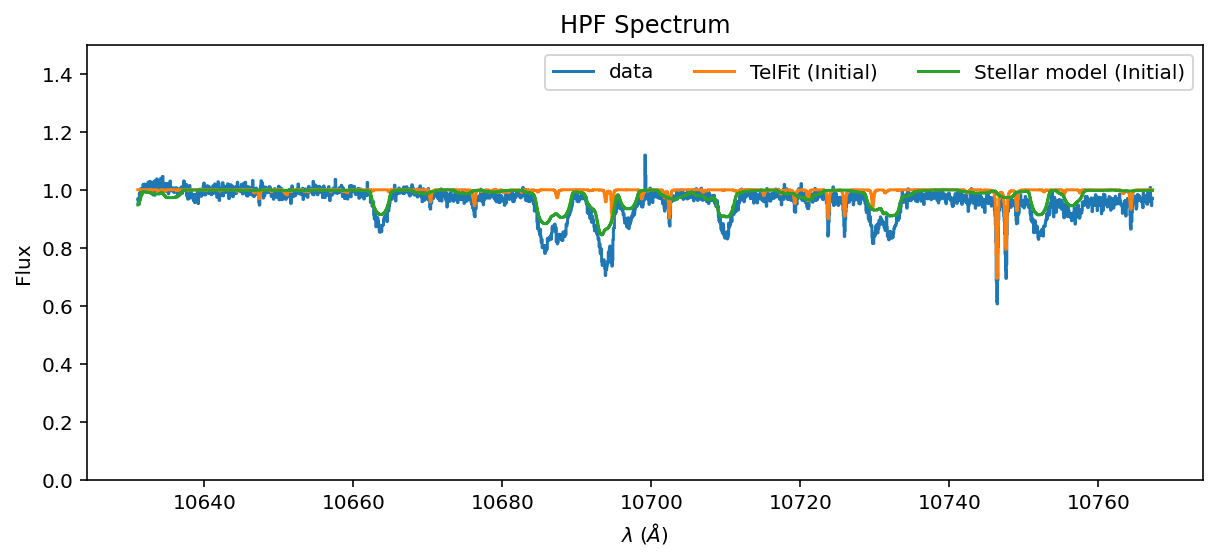

In [16]:
ax = data.plot(label='data')
initial_telluric.plot(ax=ax, label='TelFit (Initial)')
initial_guess.plot(ax=ax, label='Stellar model (Initial)')
ax.legend(ncol=3);

Ok, the lines are in the right place, but the amplitudes are inexact.  Let's tune them with `blase`!

### Clone the stellar and telluric model

In [17]:
stellar_emulator = SparseLogEmulator(spectrum.wavelength.value, 
                                     np.log(spectrum.flux.value), prominence=0.01, device=device)
stellar_emulator.to(device)

/Users/mag3842/GitHub/blase/src/blase/emulator.py:359: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.target = torch.tensor(


Initializing a sparse model with 103 spectral lines


SparseLogEmulator()

In [18]:
telluric_emulator = SparseLogEmulator(telluric_spectrum.wavelength.value, 
                                      np.log(telluric_spectrum.flux.value), 
                                      prominence=0.01, device=device)
telluric_emulator.to(device)

Initializing a sparse model with 63 spectral lines


SparseLogEmulator()

### Fine-tune the clone

In [19]:
stellar_emulator.optimize(epochs=1000, LR=0.01)

Training Loss: 0.00009763: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 85.63it/s]


In [20]:
telluric_emulator.optimize(epochs=1000, LR=0.01)

Training Loss: 0.00000097: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 94.67it/s]


### Step 3: Extrinsic model

In [21]:
extrinsic_layer = ExtrinsicModel(wavelength_grid, device=device)
vsini = torch.tensor(vsini)
extrinsic_layer.ln_vsini.data = torch.log(vsini)
extrinsic_layer.to(device)

ExtrinsicModel()

(Remap the stellar and telluric emulator to a standardized wavelength grid).

In [22]:
stellar_emulator = SparseLogEmulator(wavelength_grid, 
                                     init_state_dict=stellar_emulator.state_dict(), device=device)
stellar_emulator.radial_velocity.data = torch.tensor(observed_RV)
stellar_emulator.to(device)
telluric_emulator = SparseLogEmulator(wavelength_grid, 
                                     init_state_dict=telluric_emulator.state_dict(), device=device)
telluric_emulator.to(device)

Initializing a sparse model with 103 spectral lines
Initializing a sparse model with 63 spectral lines


SparseLogEmulator()

#### Forward model

In [23]:
stellar_flux = stellar_emulator.forward()
broadened_flux = extrinsic_layer(stellar_flux)
telluric_attenuation = telluric_emulator.forward()

#### Joint telluric and stellar model

In [24]:
flux_at_telescope = broadened_flux * telluric_attenuation

#### Instrumental model

In [25]:
instrumental_model = InstrumentalModel(data.bin_edges.value, wavelength_grid, device=device)
instrumental_model.to(device)

InstrumentalModel(
  (linear_model): Linear(in_features=5, out_features=1, bias=True)
)

In [26]:
instrumental_model.ln_sigma_angs.data = torch.log(torch.tensor(0.064))

In [27]:
detector_flux = instrumental_model.forward(flux_at_telescope)

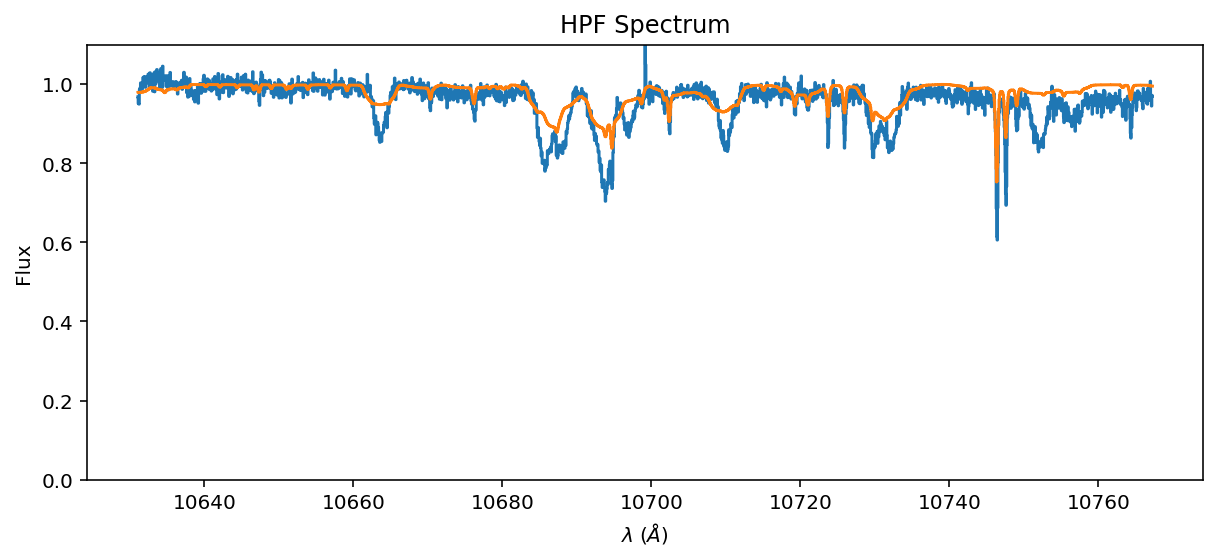

In [28]:
ax = data.plot(yhi=1.1)
ax.step(data.wavelength, detector_flux.detach().cpu().numpy());
#ax.set_xlim(8320, 8340)

## Transfer learn a semi-empirical model

Here we compare the resampled joint model to the observed data to "transfer learn" underlying super resolution spectra.

In [29]:
from torch import nn
from tqdm import trange
import torch.optim as optim

In [30]:
data_target = torch.tensor(
    data.flux.value.astype(np.float64), device=device, dtype=torch.float64
)

data_wavelength = torch.tensor(
    data.wavelength.value.astype(np.float64), device=device, dtype=torch.float64
)

In [31]:
loss_fn = nn.MSELoss(reduction="mean")

### Fix certain parameters, allow others to vary
As we have seen before, you can fix parameters by "turning off their gradients".  We will start by turning off *ALL* gradients.  Then turn on some.

In [32]:
# Fix all stellar parameters except amplitude and RV
stellar_emulator.amplitudes.requires_grad = True
stellar_emulator.radial_velocity.requires_grad = True
stellar_emulator.lam_centers.requires_grad = False
stellar_emulator.sigma_widths.requires_grad = False
stellar_emulator.gamma_widths.requires_grad = False
stellar_emulator.a_coeff.requires_grad = False
stellar_emulator.b_coeff.requires_grad = False
stellar_emulator.c_coeff.requires_grad = False

# Fix all telluric parameters, except amplitude
telluric_emulator.amplitudes.requires_grad = True
telluric_emulator.radial_velocity.requires_grad = False
telluric_emulator.lam_centers.requires_grad = False
telluric_emulator.sigma_widths.requires_grad = False
telluric_emulator.gamma_widths.requires_grad = False
telluric_emulator.a_coeff.requires_grad = False
telluric_emulator.b_coeff.requires_grad = False
telluric_emulator.c_coeff.requires_grad = False

# Fix all instrument parameters
instrumental_model.ln_sigma_angs.requires_grad = True
instrumental_model.linear_model.weight.requires_grad = True
instrumental_model.linear_model.bias.requires_grad = True

# Allow vsini to vary
extrinsic_layer.ln_vsini.requires_grad = True

In [33]:
tuning_params = list(filter(lambda p: p.requires_grad, stellar_emulator.parameters())) \
    + list(filter(lambda p: p.requires_grad, telluric_emulator.parameters())) \
    + list(filter(lambda p: p.requires_grad, extrinsic_layer.parameters())) \
    + list(filter(lambda p: p.requires_grad, instrumental_model.parameters())) 

In [34]:
tuning_params

[Parameter containing:
 tensor([-2.5781, -3.9154, -4.9371, -5.5367, -3.3469, -6.3085, -6.0335, -6.2964,
         -5.7592, -5.1981, -5.7198, -5.7229, -6.5627, -5.5947, -5.7597, -6.5826,
         -1.4795, -5.1232, -6.2030, -3.7189, -4.4699, -3.6059, -6.0769, -5.6298,
         -6.1696, -4.3028, -6.0183, -6.0899, -4.0628, -2.3396, -1.5577, -1.3636,
         -6.4495, -5.1072, -4.7403, -1.9331, -5.1129, -1.0145, -5.3678, -6.4797,
         -1.8226, -5.5399, -5.8570, -3.0154, -5.9145, -5.3789, -4.2574, -4.7989,
         -3.3869, -6.4657, -5.3143, -5.3981, -3.1719, -2.8575, -6.2774, -1.4202,
         -4.0183, -4.8962, -5.5658, -5.8416, -3.8446, -4.9368, -6.3089, -2.8147,
         -3.1906, -5.5656, -6.1330, -4.5841, -5.1860, -5.5011, -6.6576, -1.7500,
         -5.7992, -1.4261, -6.5522, -3.3034, -4.3070, -5.7182, -6.1379, -4.4127,
         -5.6053, -3.5987, -6.2692, -6.3273, -6.3080, -3.2848, -4.8797, -5.9014,
         -2.4089, -5.9778, -6.2795, -3.4616, -3.2041, -5.3165, -6.0726, -6.3044,
     

In [35]:
optimizer = optim.Adam(tuning_params,0.01,amsgrad=True)         

In [36]:
n_epochs = 1000
losses = []

## Regularization is fundamental

The blase model as it stands is **too flexible**.  It must have regularization to balance its propensity to overfit.

First, we need to assign uncertainty to the data in order to weigh the prior against new data:

In [37]:
# We need uncertainty to be able to compute the posterior
# Assert fixed per-pixel uncertainty for now
per_pixel_uncertainty = torch.tensor(0.01, device=device, dtype=torch.float64)

Then we need the prior.  For now, let's just apply priors on the amplitudes (almost everything else is fixed).  We need to set the regularization hyperparameter tuning.

In [38]:
stellar_amp_regularization = 2.1
telluric_amp_regularization = 2.1

In [39]:
import copy

In [40]:
with torch.no_grad():
    stellar_init_amps = copy.deepcopy(stellar_emulator.amplitudes)
    telluric_init_amps = copy.deepcopy(telluric_emulator.amplitudes)

# Define the prior on the amplitude
def ln_prior(stellar_amps, telluric_amps,):
    """
    Prior for the amplitude vector
    """
    amp_diff1 = stellar_init_amps - stellar_amps
    ln_prior1 = 0.5 * torch.sum((amp_diff1 ** 2) / (stellar_amp_regularization ** 2))
    
    amp_diff2 = telluric_init_amps - telluric_amps
    ln_prior2 = 0.5 * torch.sum((amp_diff2 ** 2) / (telluric_amp_regularization ** 2))

    return ln_prior1 + ln_prior2

In [41]:
t_iter = trange(n_epochs, desc="Training", leave=True)
for epoch in t_iter:
    stellar_emulator.train()
    telluric_emulator.train()
    extrinsic_layer.train()
    instrumental_model.train()
    
    stellar_flux = stellar_emulator.forward()
    broadened_flux = extrinsic_layer(stellar_flux)
    telluric_attenuation = telluric_emulator.forward()
    flux_at_telescope = broadened_flux * telluric_attenuation
    detector_flux = instrumental_model.forward(flux_at_telescope)
    
    loss = loss_fn(detector_flux / per_pixel_uncertainty, data_target / per_pixel_uncertainty)
    loss += ln_prior(stellar_emulator.amplitudes, telluric_emulator.amplitudes)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    t_iter.set_description("Training Loss: {:0.8f}".format(loss.item()))

Training Loss: 3.18415472: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:24<00:00, 11.77it/s]


### Spot check the transfer-learned joint model

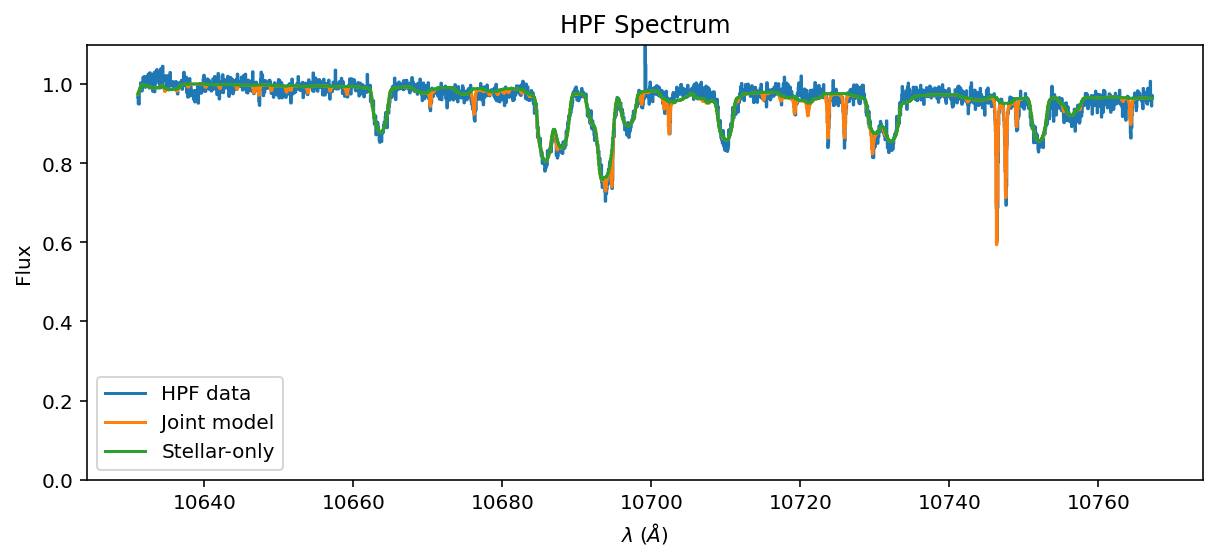

In [42]:
ax = data.plot(yhi=1.1, label='HPF data')
ax.step(data.wavelength, detector_flux.detach().cpu().numpy(), label='Joint model');
ax.step(data.wavelength, instrumental_model.forward(broadened_flux).detach().cpu().numpy(),
       label='Stellar-only');
ax.legend()

(10680.0, 10720.0)

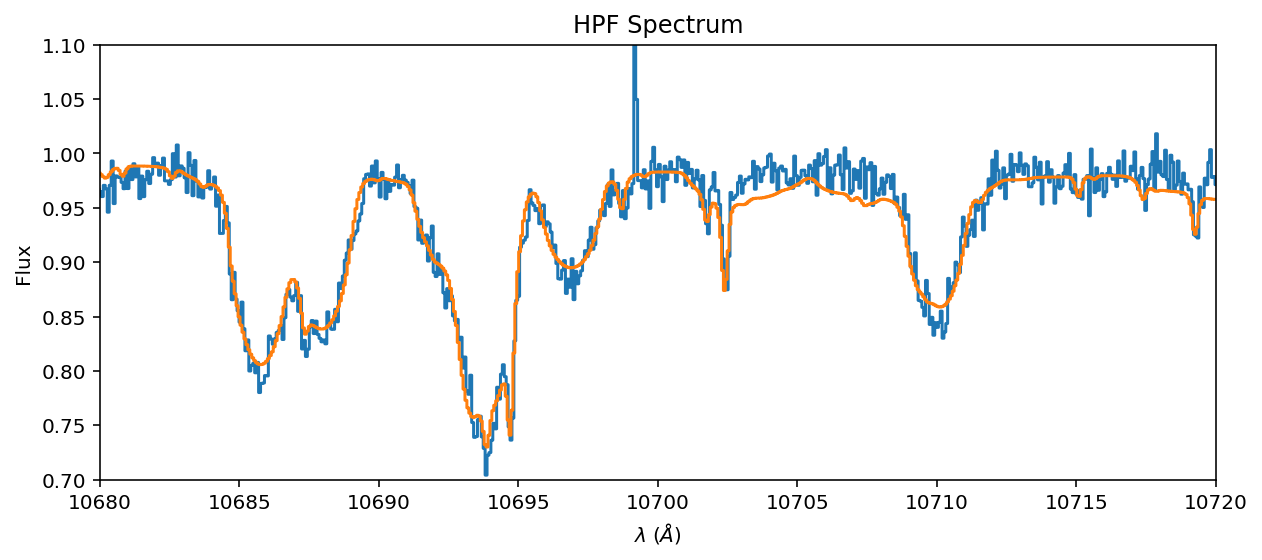

In [43]:
ax = data.plot(ylo=0.7, yhi=1.1)
ax.step(data.wavelength, detector_flux.detach().cpu().numpy());
ax.set_xlim(10680, 10720)

Don't get too excited! This performance is **very overfit**.  It needs regularization!

### Inspect the individual stellar and telluric components

In [44]:
with torch.no_grad():
    stellar_emulator.radial_velocity.data *=0
    stellar_post = stellar_emulator.forward().cpu().numpy()
    telluric_post = telluric_emulator.forward().cpu().numpy()

(10680.0, 10720.0)

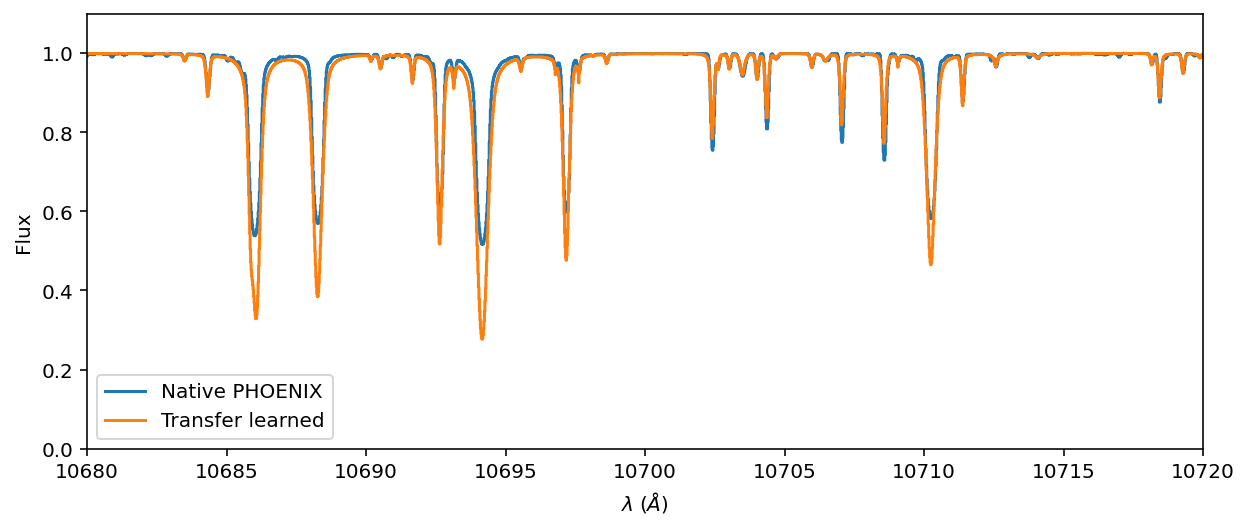

In [45]:
ax = spectrum.plot(ylo=0, yhi=1.1, label='Native PHOENIX')
ax.step(wavelength_grid, stellar_post, label='Transfer learned');
ax.legend()
ax.set_xlim(10680, 10720)

You can see that the telluric and stellar models compensated for imperfections in the line wings by overbloating the amplitudes of bystander lines.  This unlikely tradeoff makes sense once the line is convolved with an instrument kernel.

(10680.0, 10720.0)

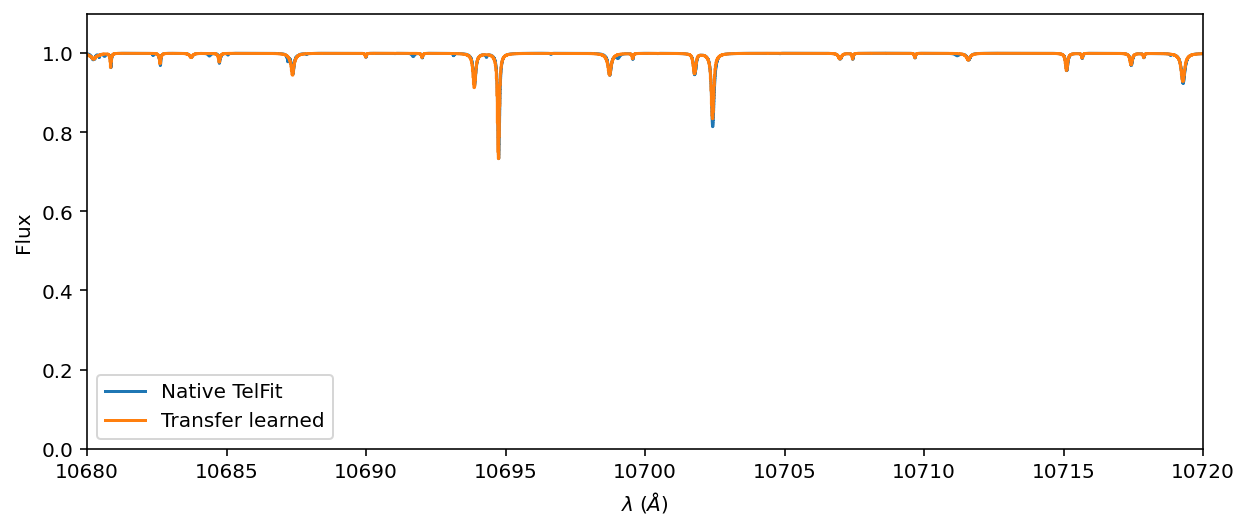

In [46]:
ax = telluric_spectrum.plot(ylo=0, yhi=1.1, label='Native TelFit')
ax.step(wavelength_grid, telluric_post, label='Transfer learned');
ax.legend()
ax.set_xlim(10680, 10720)